In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

!unzip -qq "/content/drive/MyDrive/archive.zip"

/content/drive/MyDrive
replace underwater_plastics/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace underwater_plastics/test/images/1bc7-iudfmpmn7245599_jpg.rf.c753c3518aa3bd30463da5e4b94a48be.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml

# 데이터 경로 설정
data_dir = '/content/drive/MyDrive/underwater_plastics'
folders = ['train', 'test', 'valid']
image_ext = ['.jpg']  # 필요한 이미지 확장자

In [ ]:
# 데이터 경로 확인
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    images_path = os.path.join(folder_path, 'images')
    labels_path = os.path.join(folder_path, 'labels')
    print(f"{folder} 폴더 이미지 경로: {images_path}")
    print(f"{folder} 폴더 라벨 경로: {labels_path}")

train 폴더 이미지 경로: /content/drive/MyDrive/underwater_plastics/train/images
train 폴더 라벨 경로: /content/drive/MyDrive/underwater_plastics/train/labels
test 폴더 이미지 경로: /content/drive/MyDrive/underwater_plastics/test/images
test 폴더 라벨 경로: /content/drive/MyDrive/underwater_plastics/test/labels
valid 폴더 이미지 경로: /content/drive/MyDrive/underwater_plastics/valid/images
valid 폴더 라벨 경로: /content/drive/MyDrive/underwater_plastics/valid/labels


In [ ]:
# 데이터 파일 개수 확인
image_ext = {'.jpg', '.jpeg', '.png'}
for folder in folders:
    image_files = [f for f in os.listdir(os.path.join(data_dir, folder, 'images')) if os.path.splitext(f)[1].lower() in image_ext]
    label_files = [f for f in os.listdir(os.path.join(data_dir, folder, 'labels')) if f.endswith('.txt')]
    images_count = len(image_files)
    labels_count = len(label_files)

    print(f"{folder} 폴더 이미지 개수: {images_count}")
    print(f"{folder} 폴더 라벨 개수: {labels_count}")
    print("-------------------------------------------------------------------------------------------------------------------------\n")

    if images_count != labels_count:
        print(f"이미지와 라벨 파일 개수가 다릅니다: {os.path.join(data_dir, folder)}")
        if images_count > labels_count:
            print("다음 이미지 파일들에 대응하는 라벨 파일이 없습니다:")
            for image_file in image_files:
                label_file = os.path.splitext(image_file)[0] + '.txt'
                if label_file not in label_files:
                    print(os.path.join(data_dir, folder, 'images', image_file))
        else:
            print("다음 라벨 파일들에 대응하는 이미지 파일이 없습니다:")
            for label_file in label_files:
                image_file_base = os.path.splitext(label_file)[0]
                if not any(image_file_base + ext in image_files for ext in image_ext):
                    print(os.path.join(data_dir, folder, 'labels', label_file))

train 폴더 이미지 개수: 3628
train 폴더 라벨 개수: 3628
-------------------------------------------------------------------------------------------------------------------------

test 폴더 이미지 개수: 501
test 폴더 라벨 개수: 501
-------------------------------------------------------------------------------------------------------------------------

valid 폴더 이미지 개수: 1001
valid 폴더 라벨 개수: 1007
-------------------------------------------------------------------------------------------------------------------------

이미지와 라벨 파일 개수가 다릅니다: /content/drive/MyDrive/underwater_plastics/valid
다음 라벨 파일들에 대응하는 이미지 파일이 없습니다:
/content/drive/MyDrive/underwater_plastics/valid/labels/uwg_g-1273_jpg.rf.62a8833f29759fc0122e8263c38a5a4a.txt
/content/drive/MyDrive/underwater_plastics/valid/labels/uwg_g-1293_jpg.rf.3741076eb1220c77efe9427f2c13386c.txt
/content/drive/MyDrive/underwater_plastics/valid/labels/gloves_in_the_ocean2_jpg.rf.45557ebd23757870bf38302fd19c0454.txt
/content/drive/MyDrive/underwater_plastics/valid/labels/mask_in

In [ ]:
# data.yaml 파일 내용 확인
with open(os.path.join(data_dir, 'data.yaml'), 'r') as file:
    data_yaml = yaml.safe_load(file)
print(data_yaml)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 15, 'names': ['Mask', 'can', 'cellphone', 'electronics', 'gbottle', 'glove', 'metal', 'misc', 'net', 'pbag', 'pbottle', 'plastic', 'rod', 'sunglasses', 'tire'], 'roboflow': {'workspace': 'object-detect-dmjpt', 'project': 'ocean_waste', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/object-detect-dmjpt/ocean_waste/dataset/1'}}


In [ ]:
# 각 클래스의 분포 확인
label_counts = {}
for folder in folders:
    labels_path = os.path.join(data_dir, folder, 'labels')
    for label_file in os.listdir(labels_path):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_path, label_file), 'r') as file:
                for line in file:
                    class_id = line.split()[0]
                    if class_id in label_counts:
                        label_counts[class_id] += 1
                    else:
                        label_counts[class_id] = 1

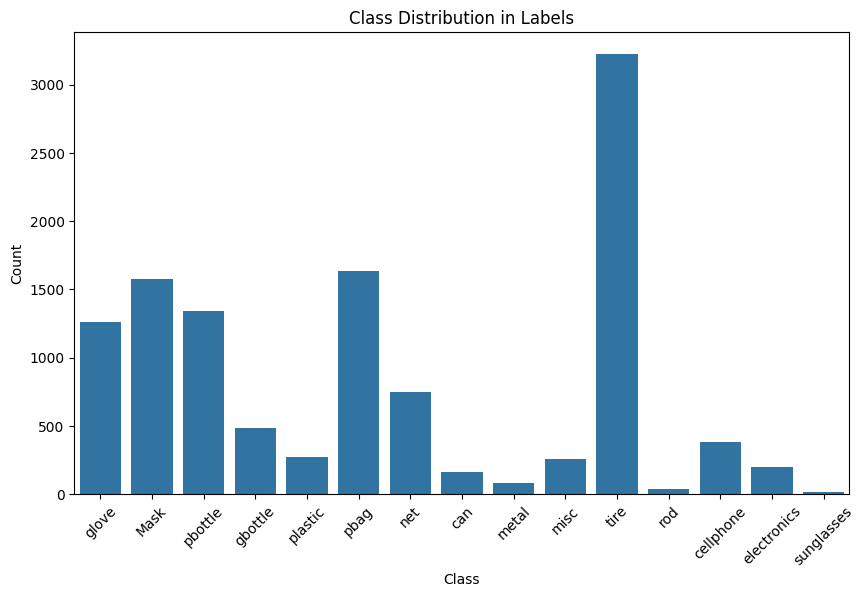

In [ ]:
# 클래스 분포 시각화
class_names = data_yaml['names']
class_counts = {class_names[int(k)]: v for k, v in label_counts.items()}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Labels')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 이미지 크기 확인
image_sizes = []
for folder in folders:
    images_path = os.path.join(data_dir, folder, 'images')
    for image_file in os.listdir(images_path):
        if os.path.splitext(image_file)[1].lower() in image_ext:
            image = cv2.imread(os.path.join(images_path, image_file))
            height, width = image.shape[:2]
            image_sizes.append((width, height))

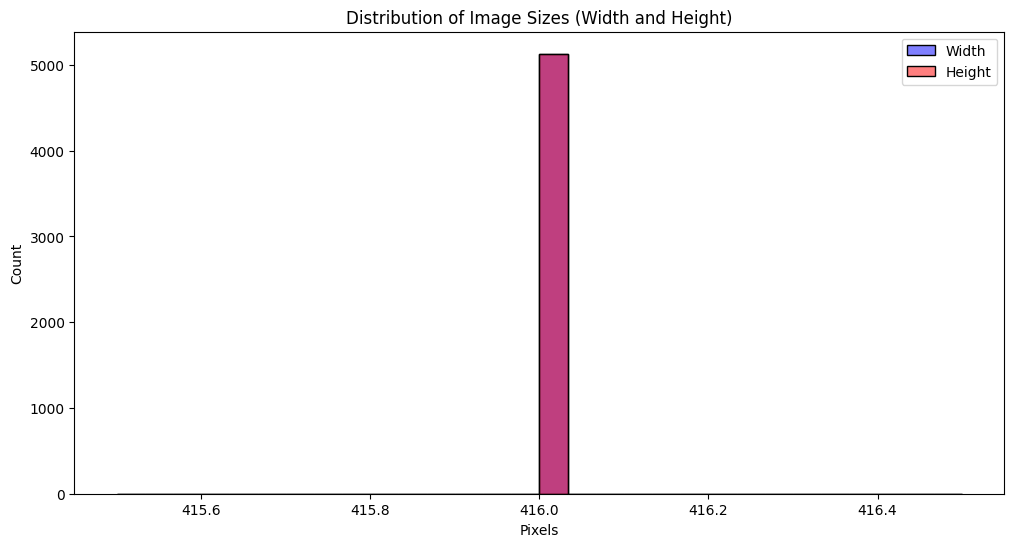

In [ ]:
# 이미지 크기 분포 시각화
image_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
plt.figure(figsize=(12, 6))
sns.histplot(image_df['Width'], bins=30, kde=True, color='blue', label='Width')
sns.histplot(image_df['Height'], bins=30, kde=True, color='red', label='Height')
plt.legend()
plt.xlabel('Pixels')
plt.title('Distribution of Image Sizes (Width and Height)')
plt.show()

In [ ]:
image_df

,Width,Height
0,416,416
1,416,416
2,416,416
3,416,416
4,416,416
...,...,...
5125,416,416
5126,416,416
5127,416,416
5128,416,416


In [ ]:
non_416_images = image_df[(image_df['Width'] != 416) | (image_df['Height'] != 416)]

# 필터링된 행들을 출력
print(non_416_images)

Empty DataFrame
Columns: [Width, Height]
Index: []


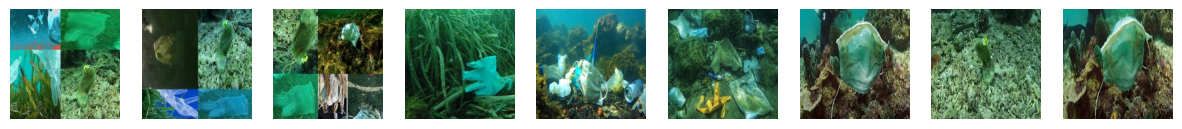

In [ ]:
# 데이터 샘플 확인
sample_images = []
for folder in folders:
    images_path = os.path.join(data_dir, folder, 'images')
    sample_images += [os.path.join(images_path, f) for f in os.listdir(images_path) if os.path.splitext(f)[1].lower() in image_ext][:3]

fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for ax, img_path in zip(axes, sample_images):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.show()

In [ ]:
import numpy as np
from PIL import Image


# 이미지 채널 통계 분석
channel_means = []
channel_stds = []

for folder in folders:
    images_path = os.path.join(data_dir, folder, 'images')
    for image_file in os.listdir(images_path):
        if os.path.splitext(image_file)[1].lower() in image_ext:
            image = np.array(Image.open(os.path.join(images_path, image_file)).convert('RGB')) / 255.0
            channel_means.append(image.mean(axis=(0, 1)))
            channel_stds.append(image.std(axis=(0, 1)))

channel_means = np.array(channel_means)
channel_stds = np.array(channel_stds)

print('채널별 평균:', channel_means.mean(axis=0))
print('채널별 표준편차:', channel_stds.mean(axis=0))

채널별 평균: [0.19014549 0.388439   0.3954532 ]
채널별 표준편차: [0.16249674 0.17228086 0.18069016]


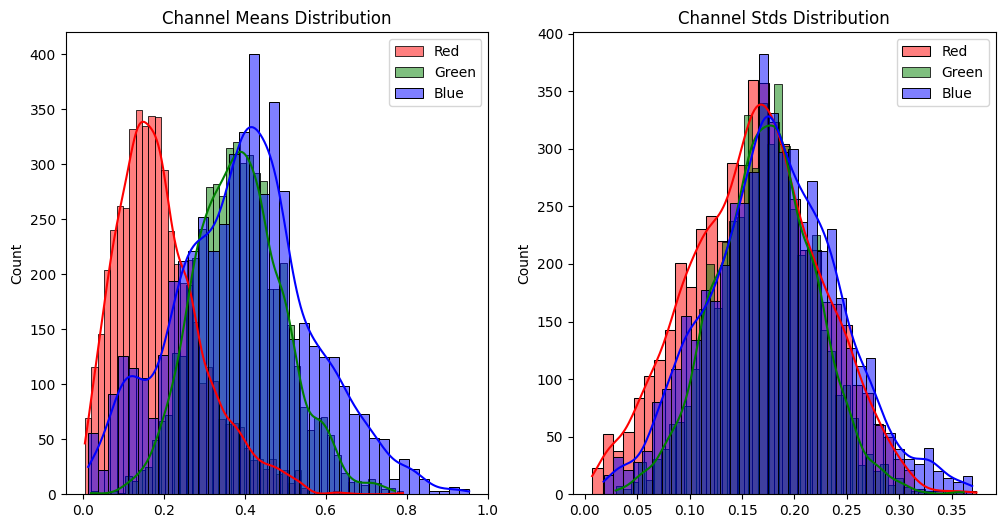

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(channel_means[:, 0], color='r', kde=True, label='Red')
sns.histplot(channel_means[:, 1], color='g', kde=True, label='Green')
sns.histplot(channel_means[:, 2], color='b', kde=True, label='Blue')
plt.title('Channel Means Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(channel_stds[:, 0], color='r', kde=True, label='Red')
sns.histplot(channel_stds[:, 1], color='g', kde=True, label='Green')
sns.histplot(channel_stds[:, 2], color='b', kde=True, label='Blue')
plt.title('Channel Stds Distribution')
plt.legend()

plt.show()

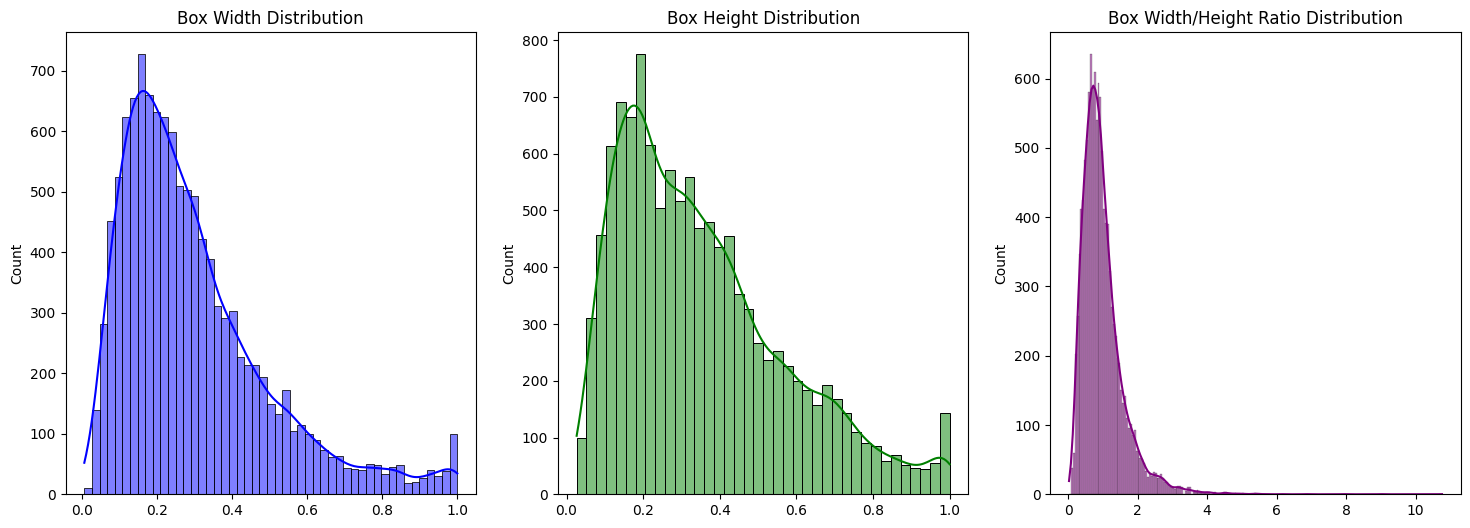

In [ ]:
# 박스 크기 및 비율 분석
box_widths = []
box_heights = []
box_ratios = []

for folder in folders:
    labels_path = os.path.join(data_dir, folder, 'labels')
    for label_file in os.listdir(labels_path):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_path, label_file), 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    x_center, y_center, width, height = map(float, parts[1:])
                    box_widths.append(width)
                    box_heights.append(height)
                    box_ratios.append(width / height)

# 시각화
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(box_widths, kde=True, color='blue')
plt.title('Box Width Distribution')

plt.subplot(1, 3, 2)
sns.histplot(box_heights, kde=True, color='green')
plt.title('Box Height Distribution')

plt.subplot(1, 3, 3)
sns.histplot(box_ratios, kde=True, color='purple')
plt.title('Box Width/Height Ratio Distribution')

plt.show()

In [ ]:
# 이미지 및 박스 시각화
def plot_image_with_boxes(image_path, boxes):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

for folder in folders:
    images_path = os.path.join(data_dir, folder, 'images')
    labels_path = os.path.join(data_dir, folder, 'labels')
    sample_images = os.listdir(images_path)[:3]
    for image_file in sample_images:
        image_path = os.path.join(images_path, image_file)
        label_file = image_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(labels_path, label_file)
        boxes = []
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                x_center, y_center, width, height = map(float, parts[1:])
                img_width, img_height = Image.open(image_path).size
                xmin = (x_center - width / 2) * img_width
                ymin = (y_center - height / 2) * img_height
                xmax = (x_center + width / 2) * img_width
                ymax = (y_center + height / 2) * img_height
                boxes.append([xmin, ymin, xmax, ymax])
        plot_image_with_boxes(image_path, boxes)